<h2>Ranking Merchants<h2>

In [34]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.sql import SparkSession, functions as F

from matplotlib.widgets import Slider, Button, RadioButtons
from ipywidgets import Layout

spark = (
    SparkSession.builder.appName("Ranking Merchants")
    .config("spark.sql.repl.eagerEval.enabled", True) 
    .config("spark.sql.parquet.cacheMetadata", "true")
    .config("spark.sql.session.timeZone", "Etc/UTC")
    .config("spark.executor.memory", "2g")
    .config("spark.driver.memory", "4g")
    .getOrCreate()
)

In [35]:
ranking_properties = spark.read.csv('../data/curated/merchant_ranking_properties.csv/', header = True).toPandas()
merchant_names = spark.read.parquet('../data/tables/tbl_merchants.parquet').toPandas()
merchant_names = merchant_names[['merchant_abn', 'name']]
ranking_properties = ranking_properties.astype(float)
segments = pd.read_csv('../data/curated/segmented_merchants.csv')

In [36]:
segments = segments[['merchant_abn', 'merchant_segments']]
segments['merchant_abn'] = segments['merchant_abn'].astype(int)

In [37]:
ranking_properties = ranking_properties.merge(segments, on = 'merchant_abn')

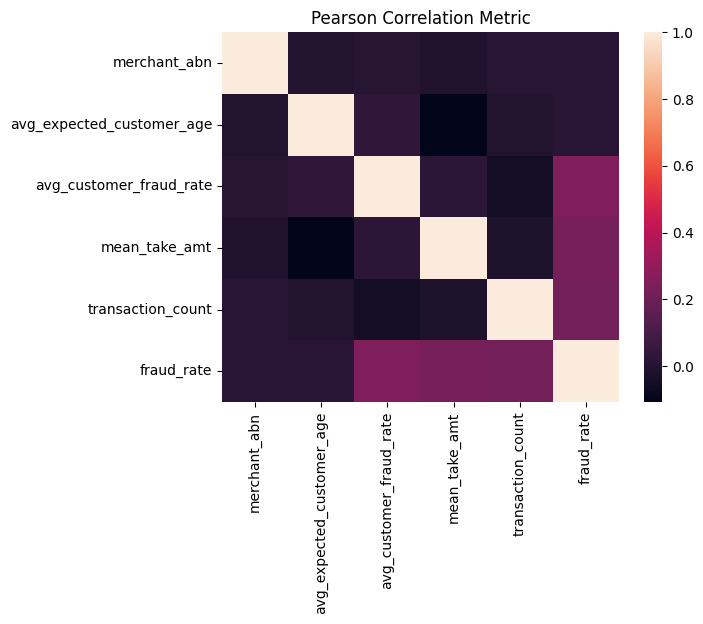

In [38]:
sns.heatmap(ranking_properties.corr())

plt.title('Pearson Correlation Metric')
plt.savefig('../plots/ranking_features_correlation.png', bbox_inches='tight')
plt.show()

Merchant fraud rate 'fraud_rate' is slightly correlated with other features but not strongly enough to remove it


<h3>Set-up for Different Ranking Methods<h3>

<h4>Weighted Average Rank<h4>

Calculate percentile ranking on each feature for every merchant

In [40]:
# Set whether we want to rank feature in ascending or descending order (if we prefer feature lower or higher)
from pyspark.sql.types import NullType


ascending = {'avg_expected_customer_age': True, 'avg_customer_fraud_rate': True, 'mean_take_amt': False, 'transaction_count': False, 'fraud_rate': True}

# Get ranking on each feature for every merchant

def get_merchant_percent_ranks(segment):

    if segment == 'All': 
        ranking_properties_segment = ranking_properties.set_index('merchant_abn')
    
    else:
        ranking_properties_segment = ranking_properties.loc[ranking_properties['merchant_segments'] == segment].set_index('merchant_abn')

    ranks = []

    #print(ranking_properties_segment)

    for col_name in (ranking_properties.columns)[1:6]:
        #print(col_name)
        ranking_properties_segment[col_name + '_rank'] = ranking_properties_segment[col_name].rank(ascending = ascending[col_name], pct = True)
        ranks.append(col_name + '_rank')
    
    #print(ranking_properties_segment)
    merchant_percent_ranks = ranking_properties_segment[ranks]

    merchant_percent_ranks_join = merchant_percent_ranks.reset_index()
    merchant_percent_ranks_join['merchant_abn'] = merchant_percent_ranks_join['merchant_abn'].astype(int)

    #ranking_properties_segment = ranking_properties.drop(ranks, axis = 1)

    return merchant_percent_ranks, merchant_percent_ranks_join




<h4>Weighted Normalised Ranking<h4>

Calculate normalised value for all features (between 0 and 1)

Change features that we want to be lower so that they are negative (thus, when we use weights to sum values maximum sum will be best)

In [41]:
def get_merchant_normalised_values(segment):

    if segment == 'All': 
        ranking_properties_segment = ranking_properties.set_index('merchant_abn').drop(['merchant_segments'], axis = 1)
    
    else:
        ranking_properties_segment = ranking_properties.loc[ranking_properties['merchant_segments'] == segment].set_index('merchant_abn').drop(['merchant_segments'], axis = 1)

    merchant_normalised_features = (ranking_properties_segment-ranking_properties_segment.min())/(ranking_properties_segment.max()-ranking_properties_segment.min())

    for col_name in merchant_normalised_features:
        if ascending[col_name]:
            merchant_normalised_features[col_name] = -1*merchant_normalised_features[col_name]

    merchant_normalised_features_join = merchant_normalised_features.reset_index()
    merchant_normalised_features_join['merchant_abn'] = merchant_normalised_features_join['merchant_abn'].astype(int)

    return merchant_normalised_features, merchant_normalised_features_join

<h3>Interactive Ranking System<h3>

In [42]:
# Set initial (internal) weights

w1 = 0.1 # Internal age weight
w2 = 1 # Internal customer fraud weight
w3 = 0.6 # Internal avg take amount weight
w4 = 1 # Internal transaction count weight
w5 = 1 # Internal merchant fraud weight

ranking_type = 'weighted average ranking'

In [43]:
from ipywidgets import interact_manual, widgets, Layout
from numpy._typing import _NBitLongDouble
from pyspark.sql.types import NullType

def weighted_average_rank(w1, w2, w3, w4, w5, segment):
    merchant_percent_ranks, merchant_percent_ranks_join = get_merchant_percent_ranks(segment)

    #print(merchant_percent_ranks)

    merchant_percent_ranks['weighted_average_rank'] = w1*merchant_percent_ranks['avg_expected_customer_age_rank'] + w2*merchant_percent_ranks['avg_customer_fraud_rate_rank']\
         + w3*merchant_percent_ranks['mean_take_amt_rank'] + w4*merchant_percent_ranks['transaction_count_rank']\
             + w5*merchant_percent_ranks['fraud_rate_rank']
    merchant_percent_ranks['rank'] = merchant_percent_ranks['weighted_average_rank'].rank()
    merchant_ranking = merchant_percent_ranks.sort_values(by=['rank'])['rank'].to_frame()
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')
    merchant_ranking = merchant_ranking.merge(merchant_percent_ranks_join, on = 'merchant_abn', how = 'outer')
    return merchant_ranking

def weighted_normalised_rank(w1, w2, w3, w4, w5, segment):

    merchant_normalised_features, merchant_normalised_features_join = get_merchant_normalised_values(segment)

    merchant_normalised_features['weighted_normalised_value'] = w1*merchant_normalised_features['avg_expected_customer_age'] + w2*merchant_normalised_features['avg_customer_fraud_rate']\
         + w3*merchant_normalised_features['mean_take_amt'] + w4*merchant_normalised_features['transaction_count']\
             + w5*merchant_normalised_features['fraud_rate']
    merchant_normalised_features['rank'] = merchant_normalised_features['weighted_normalised_value'].rank(ascending = False)
    merchant_ranking = merchant_normalised_features.sort_values(by=['rank'])['rank']
    merchant_ranking = merchant_ranking.reset_index()
    merchant_ranking['merchant_abn'] = merchant_ranking['merchant_abn'].astype(int)
    merchant_ranking = merchant_ranking.merge(merchant_names, on = 'merchant_abn', how = 'outer').set_index('rank')
    merchant_ranking = merchant_ranking.merge(merchant_normalised_features_join, on = 'merchant_abn', how = 'outer')
    return merchant_ranking
    

def update(customer_age_weight=w1, customer_fraud_weight=w2, mean_take_amt_weight=w3, transaction_count_weight=w4, fraud_rate_weight=w5,ranking_strategy=ranking_type, segment = 'All'):
    if ranking_strategy == 'weighted average rank':
        return weighted_average_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight, segment).head(10)
    elif ranking_strategy == 'weighted normalised ranking':
        return weighted_normalised_rank(customer_age_weight, customer_fraud_weight, mean_take_amt_weight, transaction_count_weight, fraud_rate_weight, segment).head(10)
    return

im = interact_manual(update, customer_age_weight=(0, 1.0, 0.01), customer_fraud_weight=(0, 1.0, 0.01), mean_take_amt_weight=(0, 1.0, 0.01), \
    transaction_count_weight=(0, 1.0, 0.01), fraud_rate_weight=(0, 1.0, 0.01), ranking_strategy=['weighted average rank', 'weighted normalised ranking'], segment=['All', 'Gardening', 'Appliances', 'Furnitures', 'IT service', 'Accessories']);

descriptions = ['Customer Age Weight----', 'Customer Fraud Weight--', 'Take Amount Weight-----', 'Transaction Count Weight', 'Merchant Fraud Weight---']

for i in range(0,5):
    im.widget.children[i].style = {'description_width': 'initial'}
    im.widget.children[i].layout = Layout(width = '45%')
    im.widget.children[i].description = descriptions[i]

im.widget.children[5].description = 'Ranking Strategy'
im.widget.children[5].style = {'description_width': 'initial'}
im.widget.children[6].description = 'Segment'
im.widget.children[7].description = 'Find Ranking'

display(im)

interactive(children=(FloatSlider(value=0.1, description='customer_age_weight', max=1.0, step=0.01), FloatSlid…

<function __main__.update(customer_age_weight=0.1, customer_fraud_weight=1, mean_take_amt_weight=0.6, transaction_count_weight=1, fraud_rate_weight=1, ranking_strategy='weighted average ranking', segment='All')>

<h2>Ranking the Top Merchants<h2>

Prefer weighted average rank because it is more resilient to extreme outliers

From research BNPL groups are primarily affiliated with large corporations with lots of sales, therefore, for rankings we will heavily weight transaction count. Additionally, they offer often offer 'no fraud liability' to merchants, meaning they are out of pocket for fraud, leading to high prioritisation of low-fraud merchants (again reflected by the weights).

<h3>Top 100 Overall<h3>

In [46]:
top_100 = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'All').head(100)
top_100

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,45380641195,Nisl Arcu Iaculis Incorporated,0.454545,0.189518,0.227273,0.094883,0.345877
1,42543374304,Morbi Metus Vivamus Inc.,0.307253,0.205166,0.158470,0.145554,0.345877
2,74063123996,Nec Eleifend Non Ltd,0.492052,0.222057,0.184302,0.103577,0.345877
3,70893725439,Luctus Curabitur Incorporated,0.328366,0.170889,0.109538,0.224292,0.345877
4,63978837398,In Tincidunt PC,0.603328,0.174367,0.162941,0.162692,0.345877
...,...,...,...,...,...,...,...
95,10323485998,Nunc Inc.,0.553900,0.337059,0.321162,0.072032,0.345877
96,12543580354,Ut Aliquam Corp.,0.616493,0.293840,0.313214,0.115499,0.345877
97,71236652596,Risus Nulla Eget Consulting,0.254595,0.259066,0.460258,0.099603,0.345877
98,29122719261,Risus Quisque Corp.,0.557874,0.202186,0.545703,0.076006,0.345877


<h3>Top 10 Each Segment<h3>

<h4>Gardening<h4>

In [47]:
top_10_gardening = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Gardening').head(10)
top_10_gardening

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,74063123996,Nec Eleifend Non Ltd,0.480480,0.216216,0.186186,0.072072,0.399399
1,75850458091,Dictum Sapien Incorporated,0.435435,0.279279,0.204204,0.099099,0.399399
2,75723980434,Velit Eget Foundation,0.279279,0.315315,0.129129,0.147147,0.399399
3,25938405651,Elementum Dui Quis Ltd,0.414414,0.204204,0.486486,0.042042,0.399399
4,90672655190,Nullam Vitae Foundation,0.270270,0.156156,0.420420,0.165165,0.399399
5,29639699851,Sodales Elit Erat Corporation,0.453453,0.420420,0.159159,0.045045,0.399399
6,82298341051,Eros Institute,0.591592,0.231231,0.207207,0.198198,0.399399
7,49925232405,Aliquam Tincidunt Nunc PC,0.378378,0.102102,0.528529,0.156156,0.399399
8,67692278478,Nullam LLP,0.330330,0.039039,0.180180,0.438438,0.399399
9,38012560280,In Tempus Associates,0.504505,0.390390,0.228228,0.048048,0.399399


<h4>Appliances<h4>

In [48]:
top_10_appliances = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Appliances').head(10)
top_10_appliances

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,45380641195,Nisl Arcu Iaculis Incorporated,0.461763,0.190309,0.217163,0.098074,0.355517
1,88279777843,Ante Maecenas LLC,0.506130,0.188558,0.171045,0.155283,0.355517
2,49536733338,Duis A Ltd,0.471103,0.210158,0.189142,0.131932,0.355517
3,88358066529,Pede Cras Vulputate Consulting,0.350846,0.326912,0.056626,0.124927,0.355517
4,98416475066,Lacinia Orci PC,0.360771,0.221833,0.310566,0.081728,0.355517
5,24015173965,Lectus Limited,0.521308,0.224168,0.250438,0.105663,0.355517
6,18303734841,Sollicitudin Orci Ltd,0.307647,0.241681,0.151197,0.180385,0.355517
7,66571984047,Volutpat Company,0.281961,0.186807,0.338587,0.137770,0.355517
8,19986358096,Hendrerit Donec Company,0.426737,0.207823,0.256276,0.154699,0.355517
9,27251742541,Malesuada Institute,0.702860,0.208406,0.165207,0.181553,0.355517


<h4>Furnitures<h4>

In [49]:
top_10_furnitures = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Furnitures').head(10)
top_10_furnitures

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,88402174457,Duis Dignissim LLC,0.560440,0.241758,0.252747,0.093407,0.32967
1,32451620193,Malesuada Augue PC,0.269231,0.296703,0.186813,0.142857,0.32967
2,92636306985,Ornare Incorporated,0.615385,0.236264,0.236264,0.175824,0.32967
3,86182863634,Luctus Vulputate Nisi Institute,0.631868,0.274725,0.214286,0.153846,0.32967
4,24471518053,Enim Suspendisse Aliquet LLP,0.543956,0.329670,0.318681,0.082418,0.32967
5,90578415511,A Scelerisque Foundation,0.395604,0.252747,0.549451,0.038462,0.32967
6,14639489823,Auctor Mauris Incorporated,0.659341,0.362637,0.192308,0.120879,0.32967
7,26148653604,Volutpat Nulla Incorporated,0.439560,0.307692,0.445055,0.049451,0.32967
8,10323485998,Nunc Inc.,0.510989,0.379121,0.329670,0.060440,0.32967
9,77690613296,Cursus Et Eros Corp.,0.582418,0.346154,0.351648,0.087912,0.32967


<h4>IT service<h4>

In [50]:
top_10_it_service = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'IT service').head(10)
top_10_it_service

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,42543374304,Morbi Metus Vivamus Inc.,0.308901,0.272251,0.026178,0.157068,0.471204
1,63978837398,In Tincidunt PC,0.612565,0.230366,0.036649,0.172775,0.471204
2,22027671078,Mauris Magna Industries,0.314136,0.287958,0.209424,0.104712,0.471204
3,87771712045,Vivamus Sit LLC,0.743455,0.293194,0.031414,0.167539,0.471204
4,45244796758,Vitae Dolor LLP,0.507853,0.356021,0.151832,0.057592,0.471204
5,22526511302,Semper Et Incorporated,0.434555,0.345550,0.068063,0.162304,0.471204
6,24351356445,At Pede Cras Corp.,0.350785,0.240838,0.094241,0.303665,0.471204
7,16165222459,Vehicula Pellentesque LLP,0.654450,0.141361,0.162304,0.335079,0.471204
8,29641342749,Et Associates,0.387435,0.445026,0.193717,0.052356,0.471204
9,92696023351,Odio Aliquam Vulputate Limited,0.146597,0.277487,0.125654,0.287958,0.471204


<h4>Accessories<h4>

In [51]:
top_10_accessories = weighted_average_rank(w1, w2, w3, w4, w5, segment = 'Accessories').head(10)
top_10_accessories

,merchant_abn,name,avg_expected_customer_age_rank,avg_customer_fraud_rate_rank,mean_take_amt_rank,transaction_count_rank,fraud_rate_rank
0,70893725439,Luctus Curabitur Incorporated,0.341630,0.165526,0.137523,0.210330,0.312694
1,27585113425,Dolor Dolor Limited,0.508401,0.143746,0.228376,0.205352,0.312694
2,73489866331,Eu Dui Cum Company,0.581829,0.200373,0.233354,0.147480,0.312694
3,88553358884,Sed Consequat Limited,0.352831,0.210330,0.401369,0.075918,0.312694
4,95184414711,Ut Eros Incorporated,0.195395,0.157436,0.388301,0.159303,0.312694
5,60650953328,Integer LLC,0.396391,0.251400,0.331052,0.095831,0.312694
6,41827752591,Fusce Aliquam Consulting,0.311761,0.101431,0.443062,0.192906,0.312694
7,20325086904,Vivamus Rhoncus Ltd,0.546982,0.253889,0.337274,0.080896,0.312694
8,38736067045,Cras Lorem Institute,0.398258,0.257623,0.367144,0.082141,0.312694
9,93644338786,Consectetuer Cursus Inc.,0.599876,0.273802,0.288737,0.103920,0.312694
